# Определение стоимости автомобилей

**Краткая информация о проекте:**
В проекте проводится прогнозирование стоимости автомобиля с помощью моделей машинного обучения (ансамблевые и неансамблевые).Для Заказчика важны следующие критерии:
- качество предсказания;
- скорость предсказания;
- время обучения.

В процессе выполения проекта проводится:

- Знакомство и предобработка данных;
- Исследовательский анализ данных (описание и визуализация);
- Корреляционный анализ (количественных и качественных признаков);
- Обучение и выбор лучшей модели машинного обучения для прогнозирования стоимости автомобиля (с учетом критериев Заказчика).

**План работы:**
1. Провести загрузку данных и знакомство с ними;
2. Провести предобработку данных;
3. Провести исследовательских анализ данных (описание и визуализацию);
4. Провести корреляционный анализ (количественных и качественных признаков);
5. Провести обучение и выбор модели с дальнейшим прогнозированием стоимости автомобиля (задача регрессии).

**Цель и задачи проекта:**
- **Цель** - обучить и выбрать модель машинного обучения для прогнозирования стоимости автомобиля с учетом обозначенных критериев Заказчика.
- **Задачи:**
1. Провести загрузку данных и знакомство с ними;
2. Провести предобработку данных;
- Обработать аномалии и неинформативные признаки;
- Обработать дубликаты и пропуски.
3. Провести исследовательских анализ данных (описание и визуализацию);
- Рассмотреть распределение количественных и качественных признаков датафрейма.
4. Провести корреляционный анализ (количественных и качественных признаков);
- Определить корреляцию между количественными и качественными признаками;
- Построить графики рассеивания по различным признакам;
- Построить графики "ящик с усами" по различным признакам.
5. Провести выбор и обучение модели с дальнейшим прогнозированием стоимости автомобиля;
- Подготовить пайплайн для обучения модели;
- Провести подбор гиперпараметров c помощью специальных функций;
- Определить лучшую модель по выбранной метрики качества и времени выполнения операций.

In [1]:
!pip install phik -q
!pip install optuna -q
!pip install -q -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

import optuna
import lightgbm as lgbm
import catboost as cb

from scipy import stats as st
from phik.report import correlation_report, plot_correlation_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, TargetEncoder,
                                   StandardScaler, RobustScaler)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

## Загрузка данных

In [3]:
def snake_case(start_list):
    result = []
    for col in start_list:
        name = ''
        for i, symbol in enumerate(col):
            if i > 0 and symbol.isupper():
                name += '_' + symbol
            else:
                name += symbol
        result.append(name.lower())
    return result

In [4]:
autos = pd.read_csv('/datasets/autos.csv')

In [5]:
display(autos.head())
autos.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
autos.columns = snake_case(autos.columns)

- В датафрейме **354 369** наблюдений и **16** признаков;
- В **5 столбцах** присутвуют пропуски, максимальное количество в столбце - `repaired`;
- Присутсвуют **три столбца** с датами создания объявлений, выгрузки анкет и последнего просмотра, которые в дальнейшем возможно будут **неинформативны** для модели;
- Наименования столбцов приведены к варианту написания snake_case.

##  Предобработка данных

### Обработка аномалий и неинформативных наблюдений и признаков

#### Обработка значений признаков date

In [7]:
display(autos.head(3))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


Изменим тип данных в столбцах с датами на `datetime`

In [8]:
df_date = pd.DataFrame(autos['date_crawled'])

for col in ['date_crawled', 'date_created', 'last_seen']:
    autos[col] = pd.to_datetime(autos[col], format='%Y-%m-%d %H:%M:%S')
    df_date[col+'y'] = autos[col].dt.year
    df_date[col+'m'] = autos[col].dt.month
df_date = df_date.drop(columns=['date_crawled'])

In [9]:
display(df_date.head(3))

,date_crawledy,date_crawledm,date_createdy,date_createdm,last_seeny,last_seenm
0,2016,3,2016,3,2016,4
1,2016,3,2016,3,2016,4
2,2016,3,2016,3,2016,4


In [10]:
df_date.describe()

,date_crawledy,date_crawledm,date_createdy,date_createdm,last_seeny,last_seenm
count,354369.0,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,2016.0,3.162387,2015.999924,3.160189,2016.0,3.564987
std,0.0,0.368806,0.009046,0.376284,0.0,0.495759
min,2016.0,3.000000,2014.000000,1.000000,2016.0,3.000000
25%,2016.0,3.000000,2016.000000,3.000000,2016.0,3.000000
50%,2016.0,3.000000,2016.000000,3.000000,2016.0,4.000000
75%,2016.0,3.000000,2016.000000,3.000000,2016.0,4.000000
max,2016.0,4.000000,2016.000000,12.000000,2016.0,4.000000


In [11]:
display(df_date.groupby(['date_createdy', 'date_createdm'])['date_createdm'].count())

date_createdy  date_createdm
2014           3                     1
2015           3                     1
               6                     1
               8                     2
               9                     3
               11                    9
               12                    9
2016           1                    70
               2                   397
               3                296757
               4                 57119
Name: date_createdm, dtype: int64

Большая часть данных относятся к временному периоду 2016-03 - 2016-04. Таким образом, для исключения шума в данных цены исключим наблюдения за 2014 и 2015 год. Также удалим столбцы с датами по причине их неинформативности.

In [12]:
autos['year'] = autos['date_created'].dt.year
autos = autos.query('year == 2016')

In [13]:
autos = autos.drop(columns=['date_crawled', 'date_created', 'last_seen', 'year'])

#### Обработка допустимых значений 

In [14]:
cat_features = list(autos.select_dtypes(include=['object']).columns)
num_features = list(autos.select_dtypes(include=['int64']).columns)

In [15]:
for col in cat_features:
    display('Количество уникальных значений в столбце {}: {}'.format(col, autos[col].nunique()))

'Количество уникальных значений в столбце vehicle_type: 8'

'Количество уникальных значений в столбце gearbox: 2'

'Количество уникальных значений в столбце model: 250'

'Количество уникальных значений в столбце fuel_type: 7'

'Количество уникальных значений в столбце brand: 40'

'Количество уникальных значений в столбце repaired: 2'

In [16]:
for col in num_features:
    display('Количество уникальных значений в столбце {}: {}'.format(col, autos[col].nunique()))

'Количество уникальных значений в столбце price: 3731'

'Количество уникальных значений в столбце registration_year: 151'

'Количество уникальных значений в столбце power: 712'

'Количество уникальных значений в столбце kilometer: 13'

'Количество уникальных значений в столбце registration_month: 13'

'Количество уникальных значений в столбце number_of_pictures: 1'

'Количество уникальных значений в столбце postal_code: 8143'

Стоит отдельно рассмотреть столбцы `price`, `power`, `registration_year` и `number_of_pictures`.

In [17]:
display('Количество уникальных значений в столбце {}: {}'.format('number_of_pictures', autos['number_of_pictures'].unique()))

'Количество уникальных значений в столбце number_of_pictures: [0]'

- **Столбец с количеством фотографий неинформативен**, так как в нем указано лишь 1 значение - 0. Данный признак предлагается **удалить**;
- Предлагается также **удалить** из датафрейма **наблюдения с целевым признаком меньше 100**;
- Предлагается также **удалить** из датафрейма **наблюдения с годом регистрации меньше 1980 года и больше года создания анкет - 2016**.

Удалим из таблицы признак с количеством фотографий и наблюдения с ценой равной 0.

In [18]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354343 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354343 non-null  int64 
 1   vehicle_type        316855 non-null  object
 2   registration_year   354343 non-null  int64 
 3   gearbox             334512 non-null  object
 4   power               354343 non-null  int64 
 5   model               334639 non-null  object
 6   kilometer           354343 non-null  int64 
 7   registration_month  354343 non-null  int64 
 8   fuel_type           321448 non-null  object
 9   brand               354343 non-null  object
 10  repaired            283193 non-null  object
 11  number_of_pictures  354343 non-null  int64 
 12  postal_code         354343 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 37.8+ MB


In [19]:
autos = autos.drop(columns=['number_of_pictures'])

In [20]:
display('Процент потери данных составит: {} %'.format(round((autos.query('price < 100').shape[0]
                                                             / autos.shape[0]) * 100, 2)))

'Процент потери данных составит: 3.76 %'

In [21]:
autos = autos.query('price >= 100')

In [22]:
display('Процент потери данных составит: {} %'.
        format(round((autos.shape[0] / autos.query('registration_year > 1980 & registration_year < 2017').
                      shape[0] - 1) * 100, 2)))

'Процент потери данных составит: 5.32 %'

In [23]:
autos = autos.query('registration_year > 1980 & registration_year < 2017')

In [24]:
display(autos.query('registration_year == 2016 & registration_month > 4')['price'].count())

4416

In [25]:
autos = autos.drop(autos[(autos['registration_year'] == 2016) & (autos['registration_month'] > 4)].index)

В таблице также присутствуют данные о регистрации автомобиля (год, месяц). В связи с малой информативностью также удалим из датафрейма столбец с месяцем регистрации авто.

In [26]:
autos = autos.drop(columns=['registration_month'])

In [27]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319400 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              319400 non-null  int64 
 1   vehicle_type       305331 non-null  object
 2   registration_year  319400 non-null  int64 
 3   gearbox            305846 non-null  object
 4   power              319400 non-null  int64 
 5   model              305573 non-null  object
 6   kilometer          319400 non-null  int64 
 7   fuel_type          298732 non-null  object
 8   brand              319400 non-null  object
 9   repaired           263844 non-null  object
 10  postal_code        319400 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 29.2+ MB


#### Обработка признака почтового индекса

In [28]:
def region(code):
    code = str(code)
    if len(code) == 4:
        code = '0' + code
    return code[:3]

В связи с тем, что почтовый индекс не несет в себе полезную информацию как таковую, он тем не менее может указывать на регион, в котором продается машина. Регион, в свою очередь, может оказывать влияние на формирование стоимости автомобиля. Для дальнейшей работы оставим в датафрейме только информацию о регионе.

In [29]:
autos['region'] = autos['postal_code'].apply(lambda x: region(x))

In [30]:
display('Количество уникальных значений почтового индекса: {}'.format(autos['postal_code'].nunique()))
display('Количество уникальных значений номера региона: {}'.format(autos['region'].nunique()))

'Количество уникальных значений почтового индекса: 8130'

'Количество уникальных значений номера региона: 671'

In [31]:
autos = autos.drop(columns=['postal_code'])

### Обработка пропусков

In [32]:
def fill_power(row, box):
    model = row['model']
    if int(row['power']) < 50 or int(row['power']) > 250:
        try:
            row['power'] = box[model]
        except:
            row['power'] = 0
    return row

In [33]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319400 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              319400 non-null  int64 
 1   vehicle_type       305331 non-null  object
 2   registration_year  319400 non-null  int64 
 3   gearbox            305846 non-null  object
 4   power              319400 non-null  int64 
 5   model              305573 non-null  object
 6   kilometer          319400 non-null  int64 
 7   fuel_type          298732 non-null  object
 8   brand              319400 non-null  object
 9   repaired           263844 non-null  object
 10  region             319400 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.2+ MB


In [34]:
display(autos[autos['vehicle_type'].isna()].head(3))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,region
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,704
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN,388
35,350,NaN,2016,manual,75,golf,150000,petrol,volkswagen,no,193


In [35]:
display(autos['vehicle_type'].unique())

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [36]:
display(autos[autos['gearbox'].isna()].head(3))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,region
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN,388
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no,441
37,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no,464


In [37]:
display(autos['gearbox'].unique())

array(['manual', 'auto', nan], dtype=object)

In [38]:
display(autos[autos['fuel_type'].isna()].head(3))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,region
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN,274
13,2500,wagon,2004,manual,131,passat,150000,NaN,volkswagen,no,907
36,1600,other,1991,manual,75,kadett,70000,NaN,opel,NaN,029


In [39]:
display(autos['fuel_type'].unique())

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [40]:
display(autos[autos['repaired'].isna()].head(3))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,region
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,704
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,904
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN,945


In [41]:
display(autos['repaired'].unique())

array([nan, 'yes', 'no'], dtype=object)

В датафрейме присутствуют пропуски в пяти столбцах `vehicle_type`, `gearbox`, `model`, `fuel_type` и `repaired`. Исходя из первичного анализа предлагается работать с пропусками в этих столбцах следующим образом:
- В связи с тем, что основная стоимость автомобиля формируется с учетом его модели, предлагается **удалить все наблюдения, с пустыми значениями моделей**;
- Столбец `repaired` является исключительным для каждого отдельного автомобиля. Предлагается **заполнить пропуски значением 'unknown'**;
- В остальных столбцах **пропуски предлагается заполнить самым популярным значением** по результату **группировки** по признаку `model`;
- Помимо этого, **предлагается заменить аномальные значения в столбце `power` на медианное значение** по результату **группировки** по признаку `model`.

In [42]:
autos = autos.dropna(subset=['model']).reset_index(drop=True)

In [43]:
autos['repaired'] = autos['repaired'].fillna('unknown')

In [44]:
box = autos.query('power > 50 & 250 > power').groupby(['model'])['power'].median()
autos = autos.apply(lambda row: fill_power(row, box), axis=1)

In [45]:
display(autos.query('power == 0').head())
display(autos.query('power == 0')['price'].count())
display(autos.query('power == 0')['model'].unique())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,region
4874,650,sedan,1985,manual,0.0,601,30000,petrol,trabant,yes,026
9932,5900,sedan,1989,manual,0.0,601,20000,petrol,trabant,no,061
15425,450,sedan,1988,manual,0.0,601,100000,petrol,trabant,unknown,175
15614,200,NaN,1990,NaN,0.0,601,5000,NaN,trabant,unknown,028
16115,560,sedan,1988,manual,0.0,601,5000,petrol,trabant,unknown,083


272

array(['601', 'range_rover_evoque'], dtype=object)

В датафрейме остались только наблюдения, где невозможно определить значение `power` по причине отсутствия данных по указанным моделям. Такие наблюдения предлагается **удалить**.

In [46]:
autos = autos.query('power > 0')

Заполним пропуски в столбах значением моды, сгруппированной по модели.

In [47]:
for col in ['vehicle_type', 'gearbox', 'fuel_type']:
    autos[col] = autos.groupby(['model'])[col].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else None)

In [48]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305301 entries, 0 to 305572
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              305301 non-null  int64  
 1   vehicle_type       305301 non-null  object 
 2   registration_year  305301 non-null  int64  
 3   gearbox            305301 non-null  object 
 4   power              305301 non-null  float64
 5   model              305301 non-null  object 
 6   kilometer          305301 non-null  int64  
 7   fuel_type          305301 non-null  object 
 8   brand              305301 non-null  object 
 9   repaired           305301 non-null  object 
 10  region             305301 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 28.0+ MB


### Обработка дубликатов

In [49]:
display('Количество явных дубликатов в датафрейме {}'.format(autos.duplicated().sum()))

'Количество явных дубликатов в датафрейме 23333'

In [50]:
display(autos[autos.duplicated()].sort_values(by=['price', 'model', 'power']).head(10))

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,region
208323,100,small,2001,manual,60.0,1_reihe,150000,petrol,peugeot,unknown,311
275376,100,small,1991,manual,68.0,1_reihe,150000,petrol,peugeot,no,096
283872,100,small,1996,manual,69.0,500,125000,petrol,fiat,no,370
146817,100,small,1997,manual,60.0,corsa,150000,petrol,opel,unknown,315
285047,100,small,1995,manual,60.0,corsa,125000,petrol,opel,unknown,192
112281,100,small,2000,manual,65.0,corsa,150000,petrol,opel,unknown,181
192098,100,small,2000,manual,65.0,corsa,150000,petrol,opel,unknown,603
215426,100,small,1997,manual,65.0,corsa,125000,petrol,opel,no,241
264378,100,small,1998,manual,65.0,corsa,150000,petrol,opel,unknown,257
59328,100,small,1995,manual,70.0,fiesta,150000,petrol,ford,yes,493


В датафрейме присутствуют **22 333** явных дубликатов. Для дальнейшей работы удалим их.

In [51]:
autos = autos.drop_duplicates().reset_index(drop=True)
display(autos.duplicated().sum())

0

In [52]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281968 entries, 0 to 281967
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              281968 non-null  int64  
 1   vehicle_type       281968 non-null  object 
 2   registration_year  281968 non-null  int64  
 3   gearbox            281968 non-null  object 
 4   power              281968 non-null  float64
 5   model              281968 non-null  object 
 6   kilometer          281968 non-null  int64  
 7   fuel_type          281968 non-null  object 
 8   brand              281968 non-null  object 
 9   repaired           281968 non-null  object 
 10  region             281968 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 23.7+ MB


### Выводы по разделу

В процессе предобработки данных были выполнены следующие шаги:
- По причине своей **неинформативности** были **удалены** столбцы: `date_crawled`, `date_created`, `last_seen`, `number_of_pictures`, `registration_month`;
- Заменен признак `postal_code` на `region`;
- Очищены от аномалий столбцы: `price` (> 0), `registration_year` (> 1970 и < 2017), `power` (> 50 и < 250);
- Обработаны пропуски в столбце `repaired` - заполнены значением 'unknown';
- Обработаны пропуски в столбцах `vehicle_type`, `gearbox`, `fuel_type` - заполнены **значением моды по группе model**;
- Удалены явные дубликаты.

Удалено данных: ***72 401 наблюдений (20.43 %)***.

## Исследовательский анализ данных

### Статистический анализ данных

In [53]:
display(autos.head())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,region
0,480,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown,704
1,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown,904
2,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,910
3,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,604
4,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes,337


In [54]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281968 entries, 0 to 281967
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              281968 non-null  int64  
 1   vehicle_type       281968 non-null  object 
 2   registration_year  281968 non-null  int64  
 3   gearbox            281968 non-null  object 
 4   power              281968 non-null  float64
 5   model              281968 non-null  object 
 6   kilometer          281968 non-null  int64  
 7   fuel_type          281968 non-null  object 
 8   brand              281968 non-null  object 
 9   repaired           281968 non-null  object 
 10  region             281968 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 23.7+ MB


Посмотрим статистические данные по количественным столбцам и построим графики boxplot

,price,registration_year,power,kilometer
count,281968.000000,281968.000000,281968.000000,281968.000000
mean,4677.363293,2002.841294,117.515424,128890.973444
std,4553.917566,5.749336,44.855308,36526.871257
min,100.000000,1981.000000,50.000000,5000.000000
25%,1250.000000,1999.000000,77.000000,125000.000000
50%,2999.000000,2003.000000,110.000000,150000.000000
75%,6750.000000,2007.000000,144.000000,150000.000000
max,20000.000000,2016.000000,250.000000,150000.000000


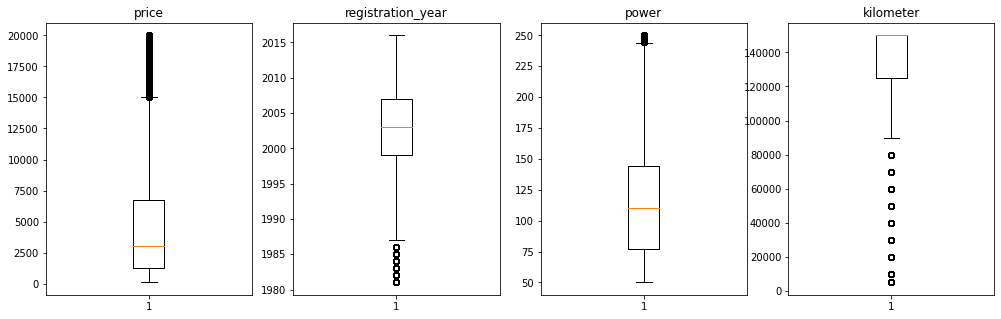

In [55]:
num_cont_features = list(autos.select_dtypes(include=['int64', 'float64']).columns)

display(autos[num_cont_features].describe())

fig, ax = plt.subplots(1, len(num_cont_features), figsize=(17, 5))

for i, col in enumerate(num_cont_features):
    ax[i].boxplot(autos[col])
    ax[i].set_title(col)
        
plt.show()

- Присутствуют **выбросы** в `price`. Данные выбросы обрабатываться не будут по причине естественности положения вещей;
- Присутствуют **выбросы** в `kilometer`. Данные выбросы обрабатываться не будут по причине естественности положения вещей.

### Визуализация данных

In [56]:
def percent(pct, table):
    absolute = int(round(pct/100 * table.sum()))
    return f"{pct:.1f}% \n{absolute}"

#### Визуализация количественных признаков 

In [57]:
num_cont_features.remove('kilometer')
display(num_cont_features)

['price', 'registration_year', 'power']

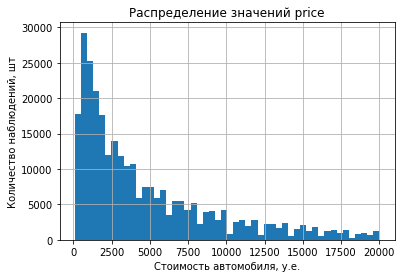

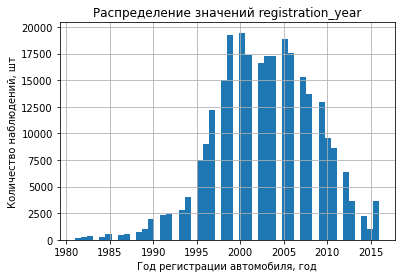

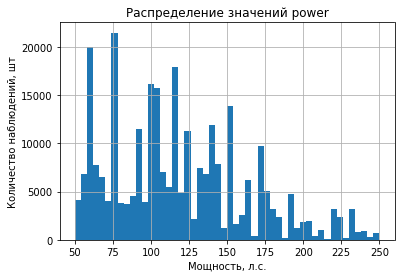

In [58]:
axes_name = {'price': ['Стоимость автомобиля', ', у.е.'],
            'registration_year': ['Год регистрации автомобиля', ', год'],
            'power': ['Мощность', ', л.с.']}

for i in range(len(num_cont_features)):
    plt.hist(autos[num_cont_features[i]], bins=50)
    plt.title(f'Распределение значений {num_cont_features[i]}')
    plt.xlabel(axes_name[num_cont_features[i]][0] + axes_name[num_cont_features[i]][1])
    plt.ylabel('Количество наблюдений, шт')
    plt.grid()
    plt.show()

Выводы по графикам **количественных признаков**:
- Распределение в столбце `price` имеет вид, приближенный к гамма распределению;
- Распределение в столбце `registration_year` имеет вид, приближенный к нормальному распределению.

#### Визуализация качественных признаков

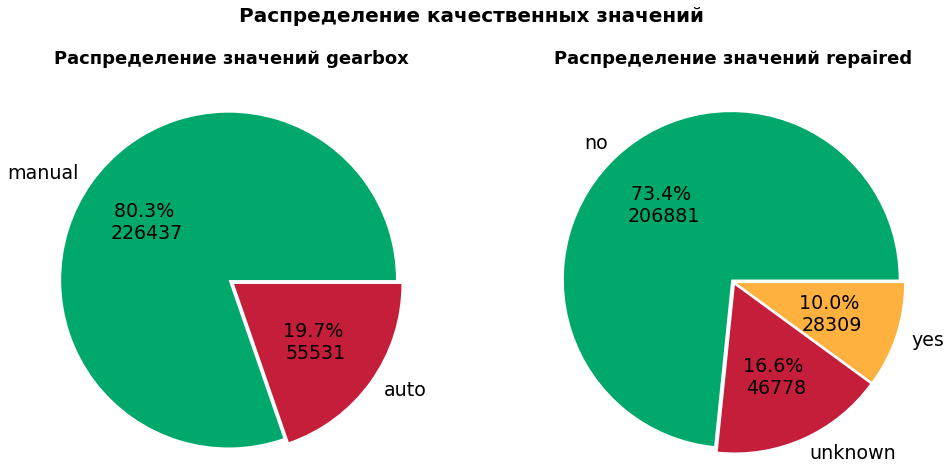

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Распределение качественных значений', size=20, weight='bold')
plt.subplots_adjust(wspace=2)
colors = ['#00A86B', '#C41E3A', '#FFB140']

for ind, column in enumerate(['gearbox', 'repaired']):
    table = autos[column].value_counts()
    wedges, texts, autotexts = ax[ind].pie(table, autopct=lambda pct: percent(pct, table), colors=colors,
                                           radius=2.5, labels=table.index, explode=[0.05 for i in range(len(table.index))])
    plt.setp(autotexts, size=19)
    plt.setp(texts, size=19)
    ax[ind].set_title(f'Распределение значений {column}', y=1.8, pad=1, fontsize=18, weight='bold')

plt.show()

'Количество групп: 8'

'Среднее количество: 35246.0'

'Количество групп со значением больше среднего: 3 - 37.5 %'

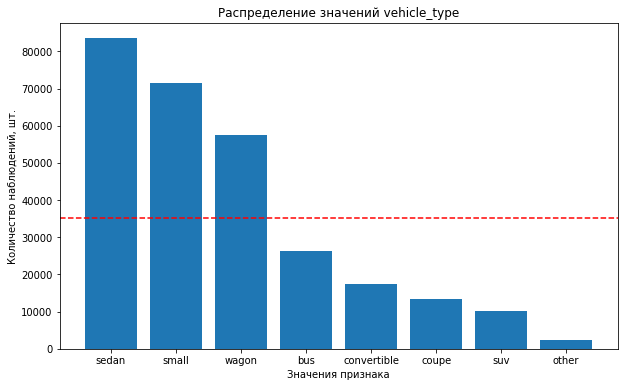

'Количество групп: 7'

'Среднее количество: 40281.14'

'Количество групп со значением больше среднего: 2 - 28.57 %'

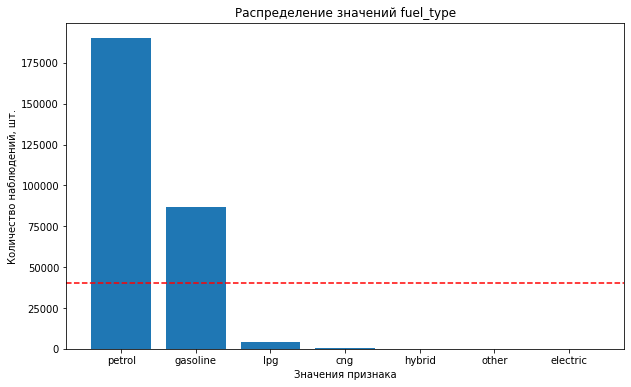

In [60]:
for column in ['vehicle_type', 'fuel_type']:
    table = autos[column].value_counts()
    mean_t = table.values.sum() / len(table.values)
    display(f'Количество групп: {len(table.values)}')
    display(f'Среднее количество: {round(mean_t, 2)}')
    group_t = table.apply(lambda x: 1 if x > round(mean_t) else 0).sum()
    display('Количество групп со значением больше среднего: {} - {} %'.format(group_t, 
                                                                              round(group_t/len(table.values) * 100, 2)))
    plt.figure(figsize=(10, 6))
    plt.bar(table.index, table.values)
    plt.axhline(y=mean_t, color='red', linestyle='--', label='mean')
    plt.title(f'Распределение значений {column}')
    plt.ylabel('Количество наблюдений, шт.')
    plt.xlabel('Значения признака')

    plt.show()

'Количество групп: 13'

'Среднее количество: 21689.85'

'Количество групп со значением больше среднего: 2 - 15.38 %'

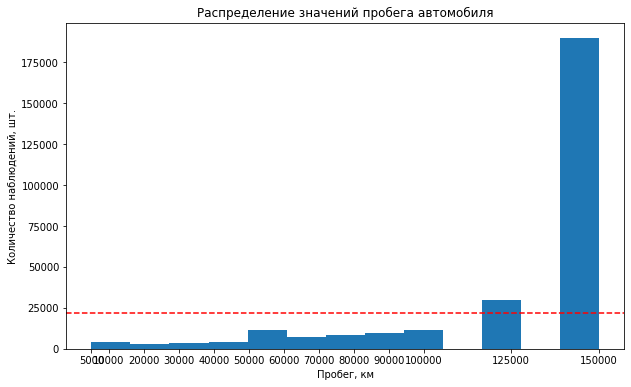

In [61]:
table = autos['kilometer'].value_counts()
mean_t = table.values.sum() / len(table.values)
display(f'Количество групп: {len(table.values)}')
display(f'Среднее количество: {round(mean_t, 2)}')
group_t = table.apply(lambda x: 1 if x > round(mean_t) else 0).sum()
display('Количество групп со значением больше среднего: {} - {} %'.format(group_t, 
                                                                          round(group_t/len(table.values) * 100, 2)))
plt.figure(figsize=(10, 6))
plt.hist(autos['kilometer'], bins=13)
plt.axhline(y=mean_t, color='red', linestyle='--', label='mean')
plt.title('Распределение значений пробега автомобиля')
plt.ylabel('Количество наблюдений, шт.')
plt.xlabel('Пробег, км')
plt.xticks(table.index)

plt.show()

'Количество групп: 39'

'Среднее количество: 7229.95'

'Количество групп со значением больше среднего: 9 - 23.08 %'

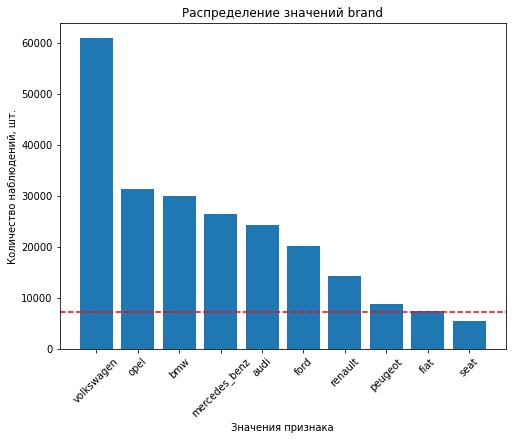

'Количество групп: 247'

'Среднее количество: 1141.57'

'Количество групп со значением больше среднего: 44 - 17.81 %'

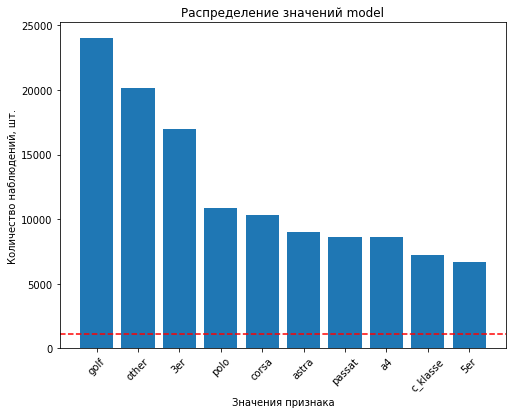

'Количество групп: 671'

'Среднее количество: 420.22'

'Количество групп со значением больше среднего: 291 - 43.37 %'

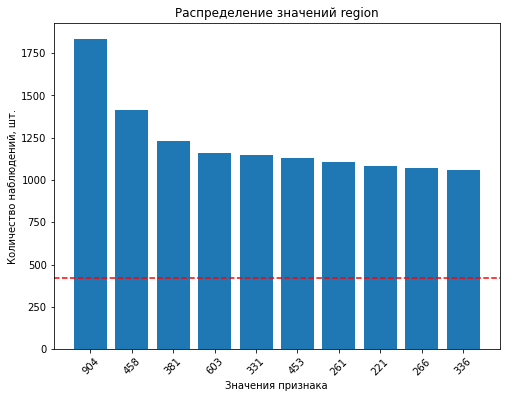

In [62]:
for column in ['brand', 'model', 'region']:
    table = autos[column].value_counts()
    mean_t = table.values.sum() / len(table.values)
    display(f'Количество групп: {len(table.values)}')
    display(f'Среднее количество: {round(mean_t, 2)}')
    group_t = table.apply(lambda x: 1 if x > round(mean_t) else 0).sum()
    display('Количество групп со значением больше среднего: {} - {} %'.format(group_t, 
                                                                              round(group_t/len(table.values) * 100, 2)))
    plt.figure(figsize=(8, 6))
    plt.bar(table[:10].index, table[:10].values)
    plt.title(f'Распределение значений {column}')
    plt.ylabel('Количество наблюдений, шт.')
    plt.xlabel('Значения признака')
    plt.xticks(rotation=45)
    plt.axhline(y=(table.values.sum() / len(table.values)), color='red', linestyle='--', label='mean')
    
    plt.show()

Выводы по графикам **качественных признаков**:
- Во входном признаке `gearbox` наблюдается дисбаланс меток. **19.7 %** продаваемых автомобилей **с автоматической коробкой передач**, остальные - **80.3 % - с механической**;
- Во входном признаке `repaired` наблюдается дисбаланс меток. **10.0 %** продаваемых автомобилей **были в ремонте**, **16.6 % - со значением неизвестно и 73.4 % никогда не были в ремонте**;
- Во входном признаке `vehicle_type` **8 групп** автомобилей со средним количеством наблюдений по группе **35 371**. Количество групп со значением больше среднего: **3 - 37.5 %**;
- Во входном признаке `fuel_type` **7 групп** автомобилей со средним количеством наблюдений по группе **40 424**. Количество групп со значением больше среднего: **2 - 28.57 %** (petrol, gasoline);
- Во входном признаке `kilometr` **13 групп** автомобилей со средним количеством наблюдений по группе **21 767**. Количество групп со значением больше среднего: **2 - 15.38 %**;
- Во входном признаке `brand` **39 групп** автомобилей со средним количеством наблюдений по группе **7 255**. Количество групп со значением больше среднего: **9 - 23.08 %**;
- Во входном признаке `model` **247 групп** автомобилей со средним количеством наблюдений по группе **1 145**. Количество групп со значением больше среднего: **44 - 17.81 %**;
- Во входном признаке `region` **671 группа** автомобилей со средним количеством наблюдений по группе **421**. Количество групп со значением больше среднего: **291 - 43.37 %**.

### Вывод по разделу 

- Присутствуют **выбросы** в `price`. Данные выбросы обрабатываться не будут по причине естественности положения вещей;
- Присутствуют **выбросы** в `kilometer`. Данные выбросы обрабатываться не будут по причине естественности положения вещей;
- Распределение в столбце `price` имеет вид, приближенный к гамма распределению;
- Распределение в столбце `registration_year` имеет вид, приближенный к нормальному распределению.
- Во входном признаке `gearbox` наблюдается дисбаланс меток. **19.7 %** продаваемых автомобилей **с автоматической коробкой передач**, остальные - **80.3 % - с механической**;
- Во входном признаке `repaired` наблюдается дисбаланс меток. **10.0 %** продаваемых автомобилей **были в ремонте**, **16.6 % - со значением неизвестно и 73.4 % никогда не были в ремонте**;
- Во входном признаке `vehicle_type` **8 групп** автомобилей со средним количеством наблюдений по группе **35 371**. Количество групп со значением больше среднего: **3 - 37.5 %**;
- Во входном признаке `fuel_type` **7 групп** автомобилей со средним количеством наблюдений по группе **40 424**. Количество групп со значением больше среднего: **2 - 28.57 %** (petrol, gasoline);
- Во входном признаке `kilometr` **13 групп** автомобилей со средним количеством наблюдений по группе **21 767**. Количество групп со значением больше среднего: **2 - 15.38 %**;
- Во входном признаке `brand` **39 групп** автомобилей со средним количеством наблюдений по группе **7 255**. Количество групп со значением больше среднего: **9 - 23.08 %**;
- Во входном признаке `model` **247 групп** автомобилей со средним количеством наблюдений по группе **1 145**. Количество групп со значением больше среднего: **44 - 17.81 %**;
- Во входном признаке `region` **671 группа** автомобилей со средним количеством наблюдений по группе **421**. Количество групп со значением больше среднего: **291 - 43.37 %**.

## Корреляционный анализ

### Определение корреляции между признаками 

In [63]:
display(autos.head())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,region
0,480,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown,704
1,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown,904
2,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no,910
3,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no,604
4,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes,337


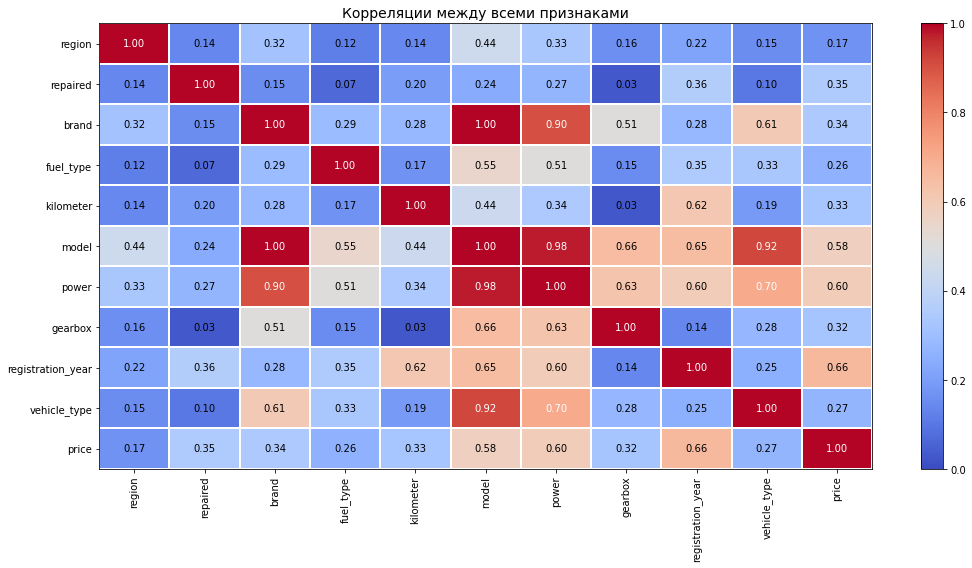

In [64]:
correlation_matrix = autos.phik_matrix(interval_cols=['price'])

plot_correlation_matrix(correlation_matrix.values, 
                        x_labels=correlation_matrix.columns, 
                        y_labels=correlation_matrix.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title='Корреляции между всеми признаками', 
                        fontsize_factor=1, 
                        figsize=(15, 8))
plt.tight_layout()

В процессе проведения корреляционного анализа была обнаружена **взаимосвязь** следующих входных признаков:
- Прямая корреляция (**1.00**) признака `model` и `brand`;
- Очень высокая корреляция (**0.98**) признака `model` и `power`;
- Очень высокая корреляция (**0.92**) признака `model` и `vehicle_type`.

Была обнаружена следующая **взаимосвязь** между целевым признаком **`price`** и входными:
- Средняя корреляция (**0,66**) с признаком `registration_year`;
- Средняя корреляция корреляция (**0,60**) с признаком `power`;
- Средняя корреляция корреляция (**0,58**) с признаком `model`.

В связи с тем, что в данных присутствует мультиколлинеарность, предлагается **удалить** столбец с **наименованием бренда автомобиля**. Данный признак сгруппирован с признаком `model`, при этом `model` имеет большую корреляцию с целевым признаком.

In [65]:
autos = autos.drop(columns=['brand'])

### Построение диаграмм рассеивания и графиков "ящик с усами" по признакам

/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


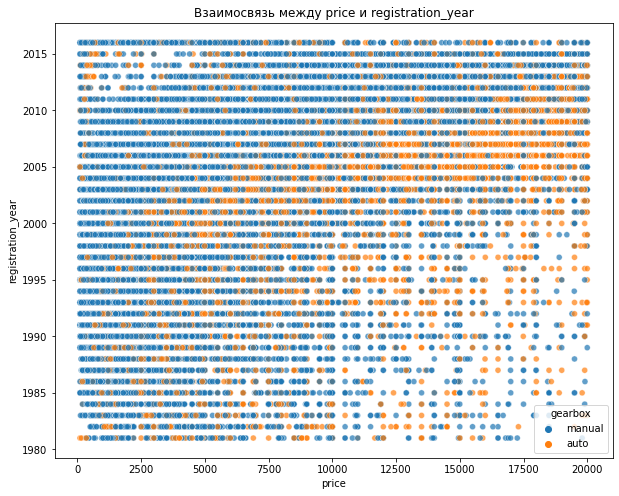

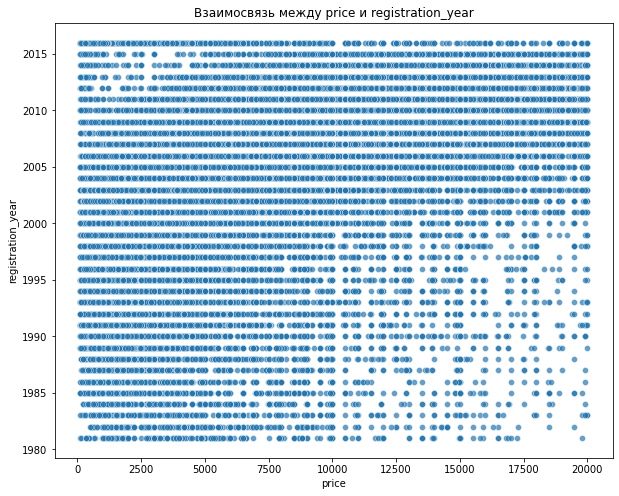

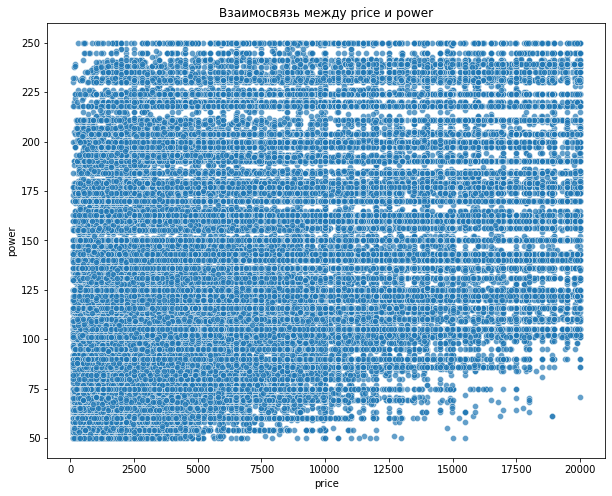

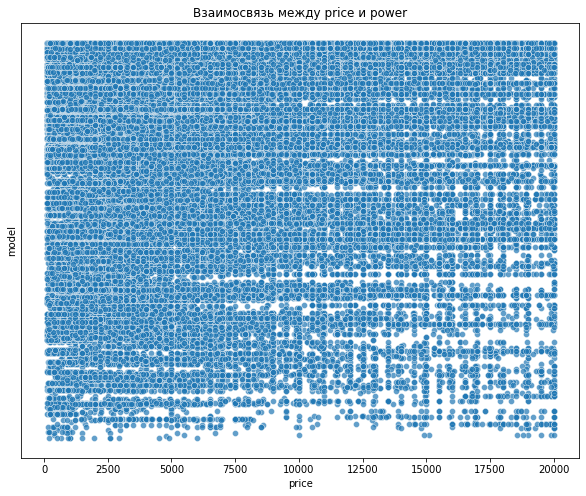

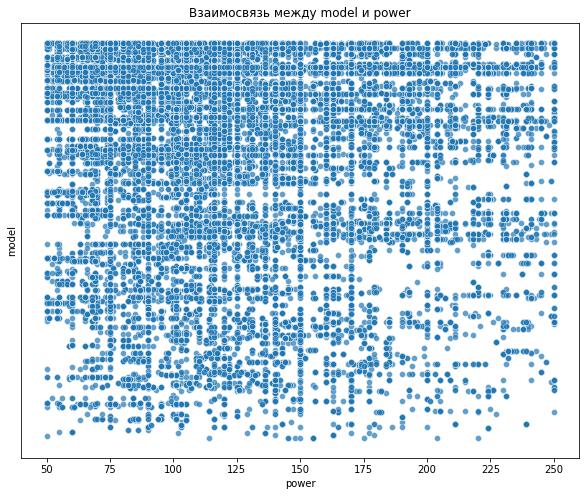

In [66]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=autos, x='price', y='registration_year',
                hue='gearbox', alpha=0.7)
plt.title('Взаимосвязь между price и registration_year')
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=autos, x='price', y='registration_year', alpha=0.7)
plt.title('Взаимосвязь между price и registration_year')
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=autos, x='price', y='power', alpha=0.7)
plt.title('Взаимосвязь между price и power')
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=autos, x='price', y='model', alpha=0.7)
plt.title('Взаимосвязь между price и power')
plt.yticks([])
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=autos, x='power', y='model', alpha=0.7)
plt.title('Взаимосвязь между model и power')
plt.yticks([])
plt.show()

### Построение графиков "ящик с усами"

,count,mean,std,min,25%,50%,75%,max
repaired,,,,,,,,
no,206881.0,5428.257332,4730.534738,100.0,1700.0,3800.0,7900.0,20000.0
unknown,46778.0,2914.541451,3437.581732,100.0,700.0,1599.0,3700.0,20000.0
yes,28309.0,2102.760536,2759.126838,100.0,500.0,1000.0,2500.0,20000.0


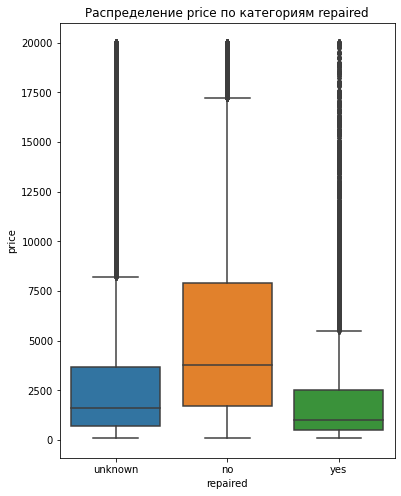

,count,mean,std,min,25%,50%,75%,max
gearbox,,,,,,,,
auto,55531.0,6977.062073,5345.751025,100.0,2499.0,5555.0,10500.0,20000.0
manual,226437.0,4113.389327,4147.390022,100.0,1100.0,2500.0,5800.0,20000.0


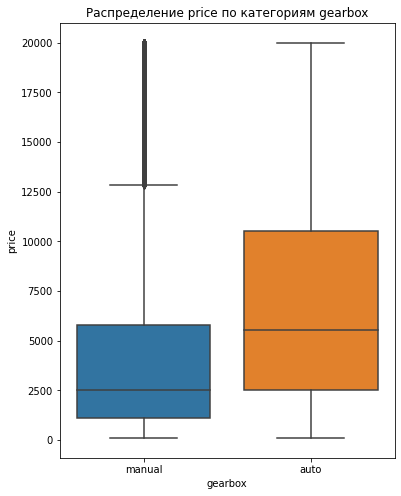

In [67]:
display(autos.groupby('repaired')['price'].describe())

plt.figure(figsize=(6, 8))
sns.boxplot(data=autos, x='repaired', y='price')
plt.title('Распределение price по категориям repaired')
plt.show()

display(autos.groupby('gearbox')['price'].describe())

plt.figure(figsize=(6, 8))
sns.boxplot(data=autos, x='gearbox', y='price')
plt.title('Распределение price по категориям gearbox')
plt.show()

**Выводы по графикам boxplot:**
- Самая высокая средняя стоимость автомобилей, не бывавших в ремонте, на втором месте - автомобили с неизвестным статусом ремонта и самая низкая средняя стоимость автомобилей, бывавших в ремонте;
- Средняя стоимость автомобилей с автоматической коробкой передач выше на 59 % стоимости автомобилей с механической коробкой передач.

### Вывод по разделу

В процессе проведения корреляционного анализа была обнаружена **взаимосвязь** следующих входных признаков:
- Прямая корреляция (**1.00**) признака `model` и `brand`;
- Очень высокая корреляция (**0.98**) признака `model` и `power`;
- Очень высокая корреляция (**0.92**) признака `model` и `vehicle_type`.

Была обнаружена следующая **взаимосвязь** между целевым признаком **`price`** и входными:
- Средняя корреляция (**0,66**) с признаком `registration_year`;
- Средняя корреляция корреляция (**0,60**) с признаком `power`;
- Средняя корреляция корреляция (**0,58**) с признаком `model`.

В связи с тем, что в данных присутствует мультиколлинеарность, был **удален** столбец с **наименованием бренда автомобиля**.

**Выводы по графикам boxplot:**
- **Самая высокая** средняя стоимость автомобилей, **не бывавших в ремонте**, на втором месте - автомобили **с неизвестным статусом ремонта** и **самая низкая** средняя стоимость автомобилей, **бывавших в ремонте**;
- Средняя **стоимость** автомобилей с **автоматической** коробкой передач **выше** на **59 %** стоимости автомобилей с **механической** коробкой передач.

## Подготовка данных для обучения

### Подготовка выборок

In [68]:
data = autos.copy()

In [69]:
X = data.drop(columns=['price'])
y = data['price']

### Подготовка данных

In [70]:
def preprocessing_data(X, y):
    numeric_features = ['power', 'kilometer']
    ohe_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']
    te_columns = ['model', 'region']
   
    other_columns = ['registration_year']
    all_without_ohe_te = ['power', 'kilometer', 'registration_year']
    
    X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.6, random_state=7)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=7)
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    
    X_val = X_val.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)
    
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # Обработка OneHotEncoder
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[ohe_columns]))
    X_train_encoded.columns = encoder.get_feature_names_out(ohe_columns)
    X_train_ohe = pd.concat([X_train[all_without_ohe_te], X_train_encoded], axis=1)
    
    X_val_encoded = pd.DataFrame(encoder.transform(X_val[ohe_columns]))
    X_val_encoded.columns = encoder.get_feature_names_out(ohe_columns)
    X_val_ohe = pd.concat([X_val[all_without_ohe_te], X_val_encoded], axis=1)
    
    X_test_encoded = pd.DataFrame(encoder.transform(X_test[ohe_columns]))
    X_test_encoded.columns = encoder.get_feature_names_out(ohe_columns)
    X_test_ohe = pd.concat([X_test[all_without_ohe_te], X_test_encoded], axis=1)
    
    # Обработка TargetEncoder
    
    categories = [X_train[col].unique() for col in te_columns]
    te = TargetEncoder(categories=categories, target_type='continuous')

    X_train_te = pd.DataFrame(te.fit_transform(X_train[te_columns], y_train))
    X_train_te.columns = te_columns
    X_train_ = pd.concat([X_train_ohe, X_train_te], axis=1)
    
    X_val_te = pd.DataFrame(te.transform(X_val[te_columns]))
    X_val_te.columns = te_columns
    X_val_ = pd.concat([X_val_ohe, X_val_te], axis=1)
    
    X_test_te = pd.DataFrame(te.transform(X_test[te_columns]))
    X_test_te.columns = te_columns
    X_test_ = pd.concat([X_test_ohe, X_test_te], axis=1)
    
    # Обработка StandardScaler
    scaler_standard = StandardScaler()
    X_train_standard = X_train_.copy()
    X_train_standard[X_train_.columns] = scaler_standard.fit_transform(X_train_)
    
    X_val_standard = X_val_.copy()
    X_val_standard[X_val_.columns] = scaler_standard.transform(X_val_)
    
    X_test_standard = X_test_.copy()
    X_test_standard[X_test_.columns] = scaler_standard.transform(X_test_)
    
    return X_train, X_val, X_test, X_train_standard, X_val_standard, X_test_standard, y_train, y_val, y_test

In [71]:
X_train, X_val, X_test, X_train_base, X_val_base, X_test_base, y_train, y_val, y_test = preprocessing_data(X, y)

## Обучение моделей

### Обучение модели линейной регрессии

In [72]:
start = time.time()
linear_model = LinearRegression().fit(X_train_base, y_train)
time_train_linear = round(time.time() - start, 2)
display(f'Время обучения линейной модели: {time_train_linear} с.')

'Время обучения линейной модели: 0.22 с.'

In [73]:
start = time.time()
y_pred = linear_model.predict(X_val_base)
time_pred_linear = round(time.time() - start, 2)
display(f'Время обучения линейной модели: {time_pred_linear} с.')

'Время обучения линейной модели: 0.09 с.'

In [74]:
rmse_linear = root_mean_squared_error(y_val, y_pred)
display(f'RMSE линейной модели равен: {round(rmse_linear)}')

'RMSE линейной модели равен: 2630'

### Обучение модели дерева решений

In [75]:
def objective_tree(trial):
    max_depth = trial.suggest_int('max_depth', 5, 25)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    model = DecisionTreeRegressor(max_depth=max_depth, 
                                  min_samples_split=min_samples_split, 
                                  random_state=7)

    model.fit(X_train_base, y_train)
    y_pred = model.predict(X_val_base)

    rmse = root_mean_squared_error(y_val, y_pred)
    
    return rmse

In [76]:
start = time.time()
study_tree = optuna.create_study(direction='minimize')  
study_tree.optimize(objective_tree, n_trials=20)  
time_sel_tree = round(time.time() - start, 2)

display(f'Время подбора гиперпараметров модели дерева решений: {time_sel_tree} с.')
display(f'Best parameters: {study_tree.best_params}')

[I 2025-06-08 08:00:07,801] A new study created in memory with name: no-name-980ca816-3fea-414a-9849-4bb27af04aef
[I 2025-06-08 08:00:08,684] Trial 0 finished with value: 2145.535745979199 and parameters: {'max_depth': 25, 'min_samples_split': 8}. Best is trial 0 with value: 2145.535745979199.
[I 2025-06-08 08:00:09,437] Trial 1 finished with value: 2060.131237511442 and parameters: {'max_depth': 24, 'min_samples_split': 14}. Best is trial 1 with value: 2060.131237511442.
[I 2025-06-08 08:00:10,210] Trial 2 finished with value: 2154.444501697002 and parameters: {'max_depth': 23, 'min_samples_split': 7}. Best is trial 1 with value: 2060.131237511442.
[I 2025-06-08 08:00:10,506] Trial 3 finished with value: 2173.1651107902157 and parameters: {'max_depth': 7, 'min_samples_split': 6}. Best is trial 1 with value: 2060.131237511442.
[I 2025-06-08 08:00:11,150] Trial 4 finished with value: 1993.0551374916631 and parameters: {'max_depth': 17, 'min_samples_split': 15}. Best is trial 4 with valu

'Время подбора гиперпараметров модели дерева решений: 11.83 с.'

"Best parameters: {'max_depth': 13, 'min_samples_split': 17}"

In [77]:
start = time.time()
tree_model = DecisionTreeRegressor(max_depth=14, min_samples_split=16, 
                                   random_state=7).fit(X_train_base, y_train)
time_train_tree = round(time.time() - start, 2)

display(f'Время обучения модели дерева решений: {time_train_tree} с.')

'Время обучения модели дерева решений: 0.57 с.'

In [78]:
start = time.time()
y_pred = tree_model.predict(X_val_base)
time_pred_tree = round(time.time() - start, 2)

display(f'Время предсказания модели дерева решений: {time_pred_tree} с.')

'Время предсказания модели дерева решений: 0.02 с.'

In [79]:
rmse_tree = root_mean_squared_error(y_val, y_pred)
display(f'RMSE модели дерево решений равен: {round(rmse_tree)}')

'RMSE модели дерево решений равен: 1971'

### Обучение модели ближайших соседей

In [80]:
knn_model = KNeighborsRegressor().fit(X_train_base, y_train)

In [81]:
param_grid = {'n_neighbors': range(5, 50)}

In [82]:
random_search = RandomizedSearchCV(knn_model, param_grid, cv=5, scoring=root_mean_squared_error)

In [83]:
start = time.time()
random_search.fit(X_train_base, y_train)
time_sel_knn = round(time.time() - start, 2)

display(f'Время подбора гиперпараметров модели ближайших соседей: {time_sel_knn} с.')

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/opt/conda/lib/python3.9/inspect.py", line 3062, in bind
    return self._bind(args, kwargs)
  File "/opt/conda/lib/python3.9/inspect.py", line 2988, in _bind
    raise TypeError(
TypeError: too many positional arguments

  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Deta

'Время подбора гиперпараметров модели ближайших соседей: 0.79 с.'

In [84]:
display('Лучшая модель и её параметры:', random_search.best_params_)

'Лучшая модель и её параметры:'

{'n_neighbors': 46}

In [85]:
start = time.time()
knn_model = KNeighborsRegressor(n_neighbors=9).fit(X_train_base, y_train)
time_train_knn = round(time.time() - start, 2)

display(f'Время обучения модели ближайших соседей: {time_train_knn} с.')

'Время обучения модели ближайших соседей: 0.01 с.'

In [86]:
start = time.time()
y_pred = knn_model.predict(X_val_base)
time_pred_knn = round(time.time() - start, 2)

display(f'Время обучения модели ближайших соседей: {time_pred_knn} с.')

'Время обучения модели ближайших соседей: 41.35 с.'

In [87]:
rmse_knn = root_mean_squared_error(y_val, y_pred)
display(f'RMSE модели дерево решений равен: {round(rmse_knn)}')

'RMSE модели дерево решений равен: 2004'

### Обучение модели случайного леса

In [88]:
def objective_ran_tree(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)

    model = RandomForestRegressor(n_estimators=n_estimators, 
                                  max_depth=max_depth, 
                                  min_samples_split=min_samples_split, 
                                  random_state=7, 
                                  oob_score=True)

    model.fit(X_train_base, y_train)
    y_pred = model.predict(X_test_base)

    rmse = root_mean_squared_error(y_test, y_pred)
    
    return rmse

In [89]:
start = time.time()
study_ran_tree = optuna.create_study(direction='minimize')  
study_ran_tree.optimize(objective_ran_tree, n_trials=10)  
time_sel_ran_tree = round(time.time() - start, 2)

display(f'Время подбора гиперпараметров модели случайного леса: {time_sel_ran_tree} с.')
display(f'Best parameters: {study_ran_tree.best_params}')

[I 2025-06-08 08:01:02,736] A new study created in memory with name: no-name-93897d80-69c0-4ee4-af20-525f2ee0cb9f
[I 2025-06-08 08:01:56,219] Trial 0 finished with value: 1734.7004778351677 and parameters: {'n_estimators': 101, 'max_depth': 21, 'min_samples_split': 11}. Best is trial 0 with value: 1734.7004778351677.
[I 2025-06-08 08:03:00,030] Trial 1 finished with value: 1741.572254994074 and parameters: {'n_estimators': 131, 'max_depth': 24, 'min_samples_split': 19}. Best is trial 0 with value: 1734.7004778351677.
[I 2025-06-08 08:04:09,139] Trial 2 finished with value: 1731.013158820387 and parameters: {'n_estimators': 131, 'max_depth': 22, 'min_samples_split': 7}. Best is trial 2 with value: 1731.013158820387.
[I 2025-06-08 08:05:28,192] Trial 3 finished with value: 1737.1055130861141 and parameters: {'n_estimators': 162, 'max_depth': 23, 'min_samples_split': 16}. Best is trial 2 with value: 1731.013158820387.
[I 2025-06-08 08:06:04,815] Trial 4 finished with value: 1797.474249593

'Время подбора гиперпараметров модели случайного леса: 547.63 с.'

"Best parameters: {'n_estimators': 131, 'max_depth': 22, 'min_samples_split': 7}"

In [90]:
start = time.time()
ran_tree_model = RandomForestRegressor(max_depth=18, min_samples_split=3, n_estimators=129, 
                                       random_state=7).fit(X_train_base, y_train)
time_train_ran_tree = round(time.time() - start, 2)

display(f'Время обучения модели случайного леса: {time_train_ran_tree} с.')

'Время обучения модели случайного леса: 59.41 с.'

In [91]:
start = time.time()
y_pred = ran_tree_model.predict(X_val_base)
time_pred_ran_tree = round(time.time() - start, 2)

display(f'Время предсказания модели случайного леса: {time_pred_ran_tree} с.')

'Время предсказания модели случайного леса: 2.79 с.'

In [92]:
rmse_ran_tree = root_mean_squared_error(y_val, y_pred)
display(f'RMSE модели случайного леса равен: {round(rmse_ran_tree)}')

'RMSE модели случайного леса равен: 1722'

### Обучение модели LightGBM

In [93]:
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
X_train[cat_features] = X_train[cat_features].astype('category')
X_val[cat_features] = X_val[cat_features].astype('category')
X_test[cat_features] = X_test[cat_features].astype('category')
display(cat_features)

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired', 'region']

In [94]:
def objective_lgbm(trial):
    params = {'objective': 'regression',
              'metric': 'root_mean_squared_error',
              'verbosity': -1,
              'boosting_type': 'gbdt',
              'random_state': 7,
              'n_estimators': 10000, 
              'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
              'num_leaves': trial.suggest_int('num_leaves', 20, 3000),
              'max_depth': trial.suggest_int('max_depth', 3, 20),
              'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
              'subsample': trial.suggest_float('subsample', 0.4, 1.0),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0)}
    
    model = lgbm.LGBMRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='root_mean_squared_error',
              callbacks=[lgbm.early_stopping(stopping_rounds=100)],
              categorical_feature=cat_features)
    
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    
    return rmse

In [95]:
start = time.time()
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=10)
time_sel_lgbm = round(time.time() - start, 2)

display(f'Время подбора гиперпараметров ансамбля lgbm: {time_sel_lgbm} с.')

[I 2025-06-08 08:11:12,931] A new study created in memory with name: no-name-04a5a85e-7c04-4a14-9eb8-97bbfe3bc543
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fuel_type', 'gearbox', 'model', 'region', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	valid_0's rmse: 1670.97


[I 2025-06-08 08:11:56,981] Trial 0 finished with value: 1670.9666549454685 and parameters: {'learning_rate': 0.2902932054951445, 'num_leaves': 384, 'max_depth': 19, 'min_child_samples': 70, 'subsample': 0.7494890576235815, 'colsample_bytree': 0.5457070589513031}. Best is trial 0 with value: 1670.9666549454685.
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fuel_type', 'gearbox', 'model', 'region', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-package

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[346]	valid_0's rmse: 1656.4


[I 2025-06-08 08:12:29,479] Trial 1 finished with value: 1656.4043935977797 and parameters: {'learning_rate': 0.1698131161078936, 'num_leaves': 2120, 'max_depth': 7, 'min_child_samples': 72, 'subsample': 0.5425277793122836, 'colsample_bytree': 0.5754654857333082}. Best is trial 1 with value: 1656.4043935977797.
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fuel_type', 'gearbox', 'model', 'region', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-package

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 1675.44


[I 2025-06-08 08:13:14,580] Trial 2 finished with value: 1675.4361147267064 and parameters: {'learning_rate': 0.29285796276101295, 'num_leaves': 2090, 'max_depth': 20, 'min_child_samples': 97, 'subsample': 0.6368214133457587, 'colsample_bytree': 0.848834150531111}. Best is trial 1 with value: 1656.4043935977797.
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fuel_type', 'gearbox', 'model', 'region', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packag

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[734]	valid_0's rmse: 1715.78


[I 2025-06-08 08:13:39,582] Trial 3 finished with value: 1715.782596630601 and parameters: {'learning_rate': 0.18384918436433195, 'num_leaves': 1535, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.9121010695505624, 'colsample_bytree': 0.8486636142495148}. Best is trial 1 with value: 1656.4043935977797.
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fuel_type', 'gearbox', 'model', 'region', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-package

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[421]	valid_0's rmse: 1654.82


[I 2025-06-08 08:14:34,674] Trial 4 finished with value: 1654.8160527639031 and parameters: {'learning_rate': 0.10052769322794886, 'num_leaves': 1221, 'max_depth': 8, 'min_child_samples': 93, 'subsample': 0.7053084641831051, 'colsample_bytree': 0.7828255169915468}. Best is trial 4 with value: 1654.8160527639031.
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fuel_type', 'gearbox', 'model', 'region', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packag

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	valid_0's rmse: 1643.44


[I 2025-06-08 08:15:46,374] Trial 5 finished with value: 1643.4370544207825 and parameters: {'learning_rate': 0.17446692063151448, 'num_leaves': 728, 'max_depth': 14, 'min_child_samples': 50, 'subsample': 0.5459821999904105, 'colsample_bytree': 0.560365484429943}. Best is trial 5 with value: 1643.4370544207825.
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fuel_type', 'gearbox', 'model', 'region', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-package

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 1650.29


[I 2025-06-08 08:16:23,884] Trial 6 finished with value: 1650.2928893552203 and parameters: {'learning_rate': 0.2058906579672603, 'num_leaves': 535, 'max_depth': 14, 'min_child_samples': 48, 'subsample': 0.9154364399908292, 'colsample_bytree': 0.7425224077810006}. Best is trial 5 with value: 1643.4370544207825.
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fuel_type', 'gearbox', 'model', 'region', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-package

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	valid_0's rmse: 1626.81


[I 2025-06-08 08:17:27,993] Trial 7 finished with value: 1626.8141759573446 and parameters: {'learning_rate': 0.1384243184621455, 'num_leaves': 519, 'max_depth': 19, 'min_child_samples': 22, 'subsample': 0.4056206557044763, 'colsample_bytree': 0.6786503259346037}. Best is trial 7 with value: 1626.8141759573446.
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fuel_type', 'gearbox', 'model', 'region', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-package

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	valid_0's rmse: 1644.21


[I 2025-06-08 08:18:09,603] Trial 8 finished with value: 1644.2065214440977 and parameters: {'learning_rate': 0.1895007110761883, 'num_leaves': 2200, 'max_depth': 10, 'min_child_samples': 62, 'subsample': 0.950687922507399, 'colsample_bytree': 0.48313706309092763}. Best is trial 7 with value: 1626.8141759573446.
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['fuel_type', 'gearbox', 'model', 'region', 'repaired', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packag

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	valid_0's rmse: 1673.19


[I 2025-06-08 08:18:32,597] Trial 9 finished with value: 1673.1859039403357 and parameters: {'learning_rate': 0.22747721854660374, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.7286606536103544, 'colsample_bytree': 0.780008892564121}. Best is trial 7 with value: 1626.8141759573446.


'Время подбора гиперпараметров ансамбля lgbm: 439.74 с.'

In [96]:
best_lgbm = lgbm.LGBMRegressor(**study_lgbm.best_params)

In [97]:
start = time.time()
best_lgbm.fit(X_train, y_train, categorical_feature=cat_features)
time_train_lgbm = round(time.time() - start, 2)

display(f'Время обучения ансамбля lgbm: {time_train_lgbm} с.')

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


'Время обучения ансамбля lgbm: 174.5 с.'

In [98]:
start = time.time()
y_pred = best_lgbm.predict(X_val)
time_pred_lgbm = round(time.time() - start, 2)

display(f'Время предсказания ансамбля lgbm: {time_pred_lgbm} с.')

'Время предсказания ансамбля lgbm: 3.2 с.'

In [99]:
rmse_lgbm = root_mean_squared_error(y_val, y_pred)
display(f'RMSE модели LightGBM равен: {round(rmse_lgbm)}')

'RMSE модели LightGBM равен: 1619'

### Обучение модели CatBoost

In [100]:
def objective_catboost(trial):
    params = {'loss_function': 'RMSE',
              'eval_metric': 'RMSE',
              'random_state': 7,
              'iterations': 10000,
              'verbose': 0, 

              'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
              'depth': trial.suggest_int('depth', 3, 16),
              'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 5.0, log=True),
              'min_data_in_leaf': trial.suggest_float('min_data_in_leaf', 3, 10.0),
              'rsm': trial.suggest_float('rsm', 0.4, 1.0)}
    
    model = cb.CatBoostRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              cat_features=cat_features,
              early_stopping_rounds=100)
    
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    
    return rmse

In [101]:
start = time.time()
study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=10)
time_sel_cb = round(time.time() - start, 2)

display(f'Время подбора гиперпараметров ансамбля CatBoost: {time_sel_cb} с.')

[I 2025-06-08 08:21:30,485] A new study created in memory with name: no-name-6ca517d9-fa23-493e-84f8-2df3ad6bb2bd
[I 2025-06-08 08:32:19,325] Trial 0 finished with value: 1673.3649339465085 and parameters: {'learning_rate': 0.052990270426555616, 'depth': 15, 'l2_leaf_reg': 0.015246264797875327, 'min_data_in_leaf': 6.048537662188686, 'rsm': 0.5794984093419185}. Best is trial 0 with value: 1673.3649339465085.
[I 2025-06-08 08:37:56,505] Trial 1 finished with value: 1661.6053867908713 and parameters: {'learning_rate': 0.10145747724090189, 'depth': 13, 'l2_leaf_reg': 0.4992305878920065, 'min_data_in_leaf': 5.608572593959586, 'rsm': 0.9399676872326372}. Best is trial 1 with value: 1661.6053867908713.
[I 2025-06-08 08:44:38,460] Trial 2 finished with value: 1648.7609231313584 and parameters: {'learning_rate': 0.11805335836150334, 'depth': 7, 'l2_leaf_reg': 1.423229211883129, 'min_data_in_leaf': 9.611103638947476, 'rsm': 0.6103144765240744}. Best is trial 2 with value: 1648.7609231313584.
[I 

'Время подбора гиперпараметров ансамбля CatBoost: 3248.75 с.'

In [102]:
best_catboost = cb.CatBoostRegressor(**study_catboost.best_params, iterations=50, verbose=0)

In [103]:
start = time.time()
best_catboost.fit(X_train, y_train, cat_features=cat_features)
time_train_cb = round(time.time() - start, 2)

display(f'Время обучения ансамбля CatBoost: {time_train_cb} с.')

'Время обучения ансамбля CatBoost: 3.12 с.'

In [104]:
start = time.time()
y_pred = best_catboost.predict(X_val)
time_pred_cb = round(time.time() - start, 2)

display(f'Время предсказания ансамбля CatBoost: {time_pred_cb} с.')

'Время предсказания ансамбля CatBoost: 0.07 с.'

In [105]:
rmse_cb = root_mean_squared_error(y_val, y_pred)
display(f'RMSE модели CatBoostRegressor равен: {round(rmse_cb)}')

'RMSE модели CatBoostRegressor равен: 1849'

### Анализ моделей и выбор оптимальной

**Критерии, которые важны Заказчику:**
- качество предсказания (RMSE < 2 500);
- время обучения модели;
- время предсказания модели.

In [106]:
time_sel_linear = 0

table = pd.DataFrame({'models': ['linear', 'decission_tree', 'knn', 'random_forest', 'lightgbm', 'catboost'],
                      'rmse': [rmse_linear, rmse_tree, rmse_knn, rmse_ran_tree, rmse_lgbm, rmse_cb],
                      'sel_param_time': [time_sel_linear, time_sel_tree, time_sel_knn, time_sel_ran_tree, time_sel_lgbm, time_sel_cb],
                      'train_time': [time_train_linear, time_train_tree, time_train_knn, time_train_ran_tree, time_train_lgbm, time_train_cb],
                      'pred_time': [time_pred_linear, time_pred_tree, time_pred_knn, time_pred_ran_tree, time_pred_lgbm, time_pred_cb]})

In [107]:
display(table)

,models,rmse,sel_param_time,train_time,pred_time
0,linear,2629.801321,0.00,0.22,0.09
1,decission_tree,1971.211521,11.83,0.57,0.02
2,knn,2003.563778,0.79,0.01,41.35
3,random_forest,1721.576744,547.63,59.41,2.79
4,lightgbm,1619.464179,439.74,174.50,3.20
5,catboost,1849.073884,3248.75,3.12,0.07


С учетом требований Заказчика сразу отбрасывается 1 модель - **linear**, так как RMSE данных моделей больше 2 500.

In [108]:
display(table.query('models != "linear"').sort_values('rmse'))

,models,rmse,sel_param_time,train_time,pred_time
4,lightgbm,1619.464179,439.74,174.50,3.20
3,random_forest,1721.576744,547.63,59.41,2.79
5,catboost,1849.073884,3248.75,3.12,0.07
1,decission_tree,1971.211521,11.83,0.57,0.02
2,knn,2003.563778,0.79,0.01,41.35


Для предсказания на тестовой выборке предлагается применить модель `LightGBM`.

In [109]:
y_pred_final = best_lgbm.predict(X_test)
rmse_final = root_mean_squared_error(y_test, y_pred_final)
display(f'RMSE лучшей модели равен: {round(rmse_final)}')

'RMSE лучшей модели равен: 1635'

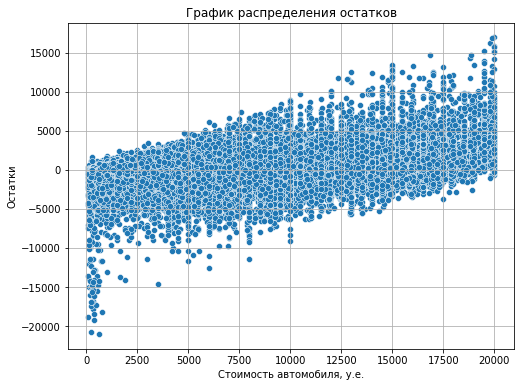

In [110]:
residuals = y_test - y_pred_final

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=1)
plt.title('График распределения остатков')
plt.xlabel('Стоимость автомобиля, у.е.')
plt.ylabel('Остатки')
plt.grid()
plt.show()

**Вывод по графику:** итоговая модель завышает стоимость дешевых автомоибилей и занижает стоимость дорогих автомобилей. 

### Вывод по разделу

В процессе обучения моделей и предсказания таргета были выполнены следующие шаги:
1. Подготовлен пайплайн по обработке данных для неансамблевых моделей;
2. Совершен подбор гиперпараметров моделей МО с помощью RandomizedSearchCV и Optuna. В качестве моделей были предложены `LinearRegression`, `DecisionTreeRegressor`, `KNeighborsRegressor`, `RandomForestRegressor`, `LGBMRegressor` и `CatBoostRegressor`. Для оценки качества модели использовалась метрика `RMSE`;
3. По результатам подбора была выбрана следующая модель: `LGBMRegressor('learning_rate': 0.1384243184621455, 'num_leaves': 519, 'max_depth': 19, 'min_child_samples': 22, 'subsample': 0.4056206557044763, 'colsample_bytree': 0.6786503259346037)`.

Значения метрики качества на валидационной выборке - **1619**; на тестовой выборке - **1635**. Время подбора гиперпараметров - **440** с., обучения - **174.5** с., предсказания - **3.2** с.

## Итоговые выводы

**В процессе выполнения проекта были выполнены следующие этапы:**
**1. Загрузка и предобработка данных:**
- Был загружен датафрейм с **354 369** наблюдениями и **16** признаками;
- Все наименования столбцов были приведены к варианту написания snake_case;
- По причине своей **неинформативности** были **удалены** столбцы: `date_crawled`, `date_created`, `last_seen`, `number_of_pictures`, `registration_month`;
- Заменен признак `postal_code` на `region`;
- Очищены от аномалий столбцы: `price` (> 0), `registration_year` (> 1970 и < 2017), `power` (> 50 и < 250);
- Обработаны пропуски в столбце `repaired` - заполнены значением 'unknown';
- Обработаны пропуски в столбцах `vehicle_type`, `gearbox`, `fuel_type` - заполнены **значением моды по группе model**;
- Удалены явные дубликаты.

Удалено данных: ***72 401 наблюдений (20.43 %)***.

**2. Исследовательский анализ данных:**
- Были обнаружены **выбросы** в `price`. Данные выбросы не обрабатывались по причине естественности положения вещей;
- Были обнаружены **выбросы** в `kilometer`. анные выбросы не обрабатывались по причине естественности положения вещей;
- Во входном признаке `gearbox` наблюдается дисбаланс меток. **19.7 %** продаваемых автомобилей **с автоматической коробкой передач**, остальные - **80.3 % - с механической**;
- Во входном признаке `repaired` наблюдается дисбаланс меток. **10.0 %** продаваемых автомобилей **были в ремонте**, **16.6 % - со значением неизвестно и 73.4 % никогда не были в ремонте**;
- Во входном признаке `vehicle_type` **8 групп** автомобилей со средним количеством наблюдений по группе **35 371**. Количество групп со значением больше среднего: **3 - 37.5 %**;
- Во входном признаке `fuel_type` **7 групп** автомобилей со средним количеством наблюдений по группе **40 424**. Количество групп со значением больше среднего: **2 - 28.57 %** (petrol, gasoline);
- Во входном признаке `kilometr` **13 групп** автомобилей со средним количеством наблюдений по группе **21 767**. Количество групп со значением больше среднего: **2 - 15.38 %**;
- Во входном признаке `brand` **39 групп** автомобилей со средним количеством наблюдений по группе **7 255**. Количество групп со значением больше среднего: **9 - 23.08 %**;
- Во входном признаке `model` **247 групп** автомобилей со средним количеством наблюдений по группе **1 145**. Количество групп со значением больше среднего: **44 - 17.81 %**;
- Во входном признаке `region` **671 группа** автомобилей со средним количеством наблюдений по группе **421**. Количество групп со значением больше среднего: **291 - 43.37 %**.

**3. Корреляционный анализ данных:**
В процессе проведения корреляционного анализа была обнаружена **взаимосвязь** следующих входных признаков:
- Прямая корреляция (**1.00**) признака `model` и `brand`;
- Очень высокая корреляция (**0.98**) признака `model` и `power`;
- Очень высокая корреляция (**0.92**) признака `model` и `vehicle_type`.

Была обнаружена следующая **взаимосвязь** между целевым признаком **`price`** и входными:
- Средняя корреляция (**0,66**) с признаком `registration_year`;
- Средняя корреляция корреляция (**0,60**) с признаком `power`;
- Средняя корреляция корреляция (**0,58**) с признаком `model`.

**Выводы по графикам boxplot:**
- **Самая высокая** средняя стоимость автомобилей, **не бывавших в ремонте**, на втором месте - автомобили **с неизвестным статусом ремонта** и **самая низкая** средняя стоимость автомобилей, **бывавших в ремонте**;
- Средняя **стоимость** автомобилей с **автоматической** коробкой передач **выше** на **58 %** стоимости автомобилей с **механической** коробкой передач.

**4. Обучение и выбор модели МО:**
- Подготовлен пайплайн по обработке данных для неансамблевых моделей;
- Совершен подбор гиперпараметров моделей МО с помощью RandomizedSearchCV и Optuna. В качестве моделей были предложены `LinearRegression`, `DecisionTreeRegressor`, `KNeighborsRegressor`, `RandomForestRegressor`, `LGBMRegressor` и `CatBoostRegressor`. Для оценки качества модели использовалась метрика `RMSE`;
3. По результатам подбора была выбрана следующая модель: `LGBMRegressor('learning_rate': 0.1384243184621455, 'num_leaves': 519, 'max_depth': 19, 'min_child_samples': 22, 'subsample': 0.4056206557044763, 'colsample_bytree': 0.6786503259346037)`.

Значения метрики качества на валидационной выборке - **1619**; на тестовой выборке - **1635**. Время подбора гиперпараметров - **440** с., обучения - **174.5** с., предсказания - **3.2** с.